In [1]:
import numpy      as np
import pandas     as pd
from   pandas     import read_csv

import tensorflow as tf
from   tensorflow import keras

import matplotlib.pyplot as plt 

##### 
### Functions

In [2]:
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

##### 
### Forecasting 1 Time Step Ahead

In [ ]:
bSize  = 10000   # batch_size
nSteps = 50      #  n_steps
series = generate_time_series( bSize, nSteps+1 )  # (10000, 51, 1)
 
a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

X_train, y_train  =  series[  :a, :nSteps ],  series[  :a, -1 ]
X_valid, y_valid  =  series[ a:b, :nSteps ],  series[ a:b, -1 ]
X_test , y_test   =  series[ b: , :nSteps ],  series[ b: , -1 ]

In [ ]:
# Baseline Metrics   # mse=0.0200    
y_pred = X_test[ :, -1 ]
MSE = np.mean( keras.losses.mean_squared_error( y_test, y_pred ) )  
print('MSE =',np.round(MSE,4))

In [ ]:
# linear model   mse=.0035   bias=51 (fast)  
model = keras.models.Sequential([           
      keras.layers.Flatten( input_shape=[ nSteps, 1 ] )
    , keras.layers.Dense( 1 )
    ]) 
model.compile( loss      = "mse"
             , optimizer = "adam"  
             )
history = model.fit( X_train, y_train
                   , epochs          =  20
                   , validation_data = (X_valid, y_valid)
                   )
y_pred = model.predict( X_test )   
MSE = np.mean( keras.losses.mean_squared_error( y_test, y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

In [ ]:
# Deep RNNs      mse=.0030   (very slow)
model = keras.models.Sequential([
    
      keras.layers.SimpleRNN( 20 
                            , return_sequences = True    
                            , input_shape = [None, 1] )
    
    , keras.layers.SimpleRNN( 20 )  
    
    , keras.layers.Dense( 1 )
    
    ]) 

model.compile( loss      = "mse"
             , optimizer = "adam"  
             )
history = model.fit( X_train, y_train
                   , epochs          =  2
                   , validation_data = (X_valid, y_valid)
                   )

y_pred = model.predict( X_test ) 
MSE = np.mean( keras.losses.mean_squared_error( y_test, y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

##### 
### Forecasting N Time Steps Ahead

In [ ]:
bSize  = 10000   # batch_size
nSteps = 50      #  n_steps 

N = 10
n_neurons =  np.max( [20, 2*N] )

In [ ]:
# one-record only     MSE=.1500
series_1 = generate_time_series( 1, nSteps+N )   # (1, 60, 1)

X_new = series_1[ : , :nSteps ]                  # (1, 50, 1)
Y_new = series_1[ : , nSteps: ]                  # (1, 10, 1)

model = keras.models.Sequential([
    
      keras.layers.SimpleRNN( n_neurons 
                            , return_sequences = True    
                            , input_shape = [None, 1] )
    
    , keras.layers.SimpleRNN( n_neurons )  
    
    , keras.layers.Dense( 1 )
    
    ])

model.compile( loss      = "mse"
             , optimizer = "adam"  
             )
history = model.fit( X_train, y_train
                   , epochs          =  2
                   , validation_data = (X_valid, y_valid)
                   )

X = X_new   
for step_ahead in range(N):
    y_pred_one = model.predict( X[ : , step_ahead: ])[ : , np.newaxis , : ]
    X          = np.concatenate([ X , y_pred_one ], axis=1 )
    
Y_pred = X[:, nSteps:] 
MSE = np.mean( keras.losses.mean_squared_error( Y_new, Y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

In [ ]:
# a-batch-of-records  MSE=.0300 
series = generate_time_series( bSize, nSteps+N )
 
a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 

model = keras.models.Sequential([
    
      keras.layers.SimpleRNN( n_neurons 
                            , return_sequences = True
                            , input_shape = [None, 1] )
    
    , keras.layers.SimpleRNN( n_neurons
                            , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense(N) )
    
    ])

optimizer = keras.optimizers.Adam( learning_rate=0.01 )
model.compile( loss      = "mse"
             , optimizer =  optimizer
             , metrics   = [last_time_step_mse] )
history = model.fit( X_train, Y_train
                   , epochs          =  2
                   , validation_data = (X_valid, Y_valid)
                   )

Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

##### 
## Handling Long Sequences
2 Problems:
  - unstable gradients problem.
  - Short-Term Memory

In [ ]:
# Handling Unstable Gradients  ( 1 Method Only )

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size      = units
        self.output_size     = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

model = keras.models.Sequential([
    
      keras.layers.RNN( LNSimpleRNNCell( n_neurons )
                      , return_sequences = True
                      , input_shape = [None, 1] )
    
    , keras.layers.RNN( LNSimpleRNNCell( n_neurons )
                      , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense(N) )

    ])

In [ ]:
# Handling Short-Term Memory  ( 4 Methods )

# (1.1)   good   LSTM cells: long-term memory cells 
model = keras.models.Sequential([
      keras.layers.LSTM( 20
                       , return_sequences = True
                       , input_shape = [None, 1] )
      
    , keras.layers.LSTM( 20
                       , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense( N ) )
    
    ])



# (1.2) not-bad  LSTM cells: long-term memory cells 
model = keras.models.Sequential([
    
      keras.layers.RNN( keras.layers.LSTMCell( n_neurons )
                      , return_sequences = True
                      , input_shape = [None, 1] )
    
    , keras.layers.RNN( keras.layers.LSTMCell( n_neurons )
                      , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense( N ) )
    
    ]) 



# (2) Best   1D convolutional layers 
model = keras.models.Sequential([    
    
      keras.layers.Conv1D( filters     =  n_neurons   # default is 20
                         , kernel_size =  4
                         , strides     =  2
                         , padding     = "valid"
                         , input_shape = [None, 1] )  
      
    , keras.layers.GRU( n_neurons
                      , return_sequences = True )
    
    , keras.layers.GRU( n_neurons
                      , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense( N ) )
    
    ])

model.compile( loss      = "mse"
             , optimizer = "adam"
             , metrics   = [last_time_step_mse] )

history = model.fit( X_train, Y_train[:, 3::2]
                   , epochs = 20
                   , validation_data = ( X_valid, Y_valid[:, 3::2] ) )



# (3) Best   WaveNet 
model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))

model.compile( loss      = "mse"
             , optimizer = "adam"
             , metrics   = [last_time_step_mse]
             )

history = model.fit( X_train, Y_train
                   , epochs          =  20
                   , validation_data = (X_valid, Y_valid)
                   )

##### 
## Project 2:   Yearly Shampoo Sales

In [51]:
Project_Name = 'Yearly_Shampoo_Sales'

df = read_csv('Yearly_Shampoo_Sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df.head(5)

Month
1-01    266.0
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
Name: Sales, dtype: float64

In [52]:
S = df.values.astype('float32') 
S

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9],
      dtype=float32)

In [53]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [54]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.9,1.1)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [55]:
N      = 18
nBatch = 15000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [56]:
# Method_3   Best (1) 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))

 
print('Model Defined.')

Model Defined.


##### 

In [75]:
model.compile( loss      = "mse"
             , optimizer = "adam"
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  10
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/10
329/329 [==============================] - 20s 48ms/step - loss: 402.6231 - last_time_step_mse: 746.2162 - val_loss: 375.9295 - val_last_time_step_mse: 691.5190
Epoch 2/10
329/329 [==============================] - 17s 52ms/step - loss: 383.9450 - last_time_step_mse: 710.1263 - val_loss: 446.2405 - val_last_time_step_mse: 884.4453
Epoch 3/10
329/329 [==============================] - 19s 58ms/step - loss: 385.3892 - last_time_step_mse: 712.6399 - val_loss: 407.3163 - val_last_time_step_mse: 744.5674
Epoch 4/10
329/329 [==============================] - 20s 60ms/step - loss: 379.3709 - last_time_step_mse: 702.6575 - val_loss: 379.8407 - val_last_time_step_mse: 704.0067
Epoch 5/10
329/329 [==============================] - 20s 60ms/step - loss: 381.3337 - last_time_step_mse: 706.6922 - val_loss: 376.1483 - val_last_time_step_mse: 693.8399
Epoch 6/10
329/329 [==============================] - 18s 55ms/step - loss: 378.0389 - last_time_step_mse: 700.3792 - val_loss: 374.3759 - v

In [76]:
Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))


RMSE = 19.3298


##### 

In [77]:
# save weights
version = '204'

model.save_weights( Project_Name + '_' + version
                  , overwrite = True 
                  , save_format = None 
                  , options = None 
                  )

##### 

In [40]:
# load weights
version = '201'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [78]:
print('[   true  pred    diff ]')
for i in range(N):
    x1 = df.tail(N).values[i]
    x2 = int(  np.round(Y_pred[-1][-1])[i]  )
    dx = np.round( (x2-x1)/x1 , 2 )
    print('[ ', x1,' ', x2,' ',dx, ']')

[   true  pred    diff ]
[  226.0   224   -0.01 ]
[  303.6   301   -0.01 ]
[  289.9   285   -0.02 ]
[  421.6   417   -0.01 ]
[  264.5   263   -0.01 ]
[  342.3   339   -0.01 ]
[  339.7   336   -0.01 ]
[  440.4   437   -0.01 ]
[  315.9   312   -0.01 ]
[  439.3   432   -0.02 ]
[  401.3   400   -0.0 ]
[  437.4   434   -0.01 ]
[  575.5   575   -0.0 ]
[  407.6   405   -0.01 ]
[  682.0   678   -0.01 ]
[  475.3   477   0.0 ]
[  581.3   577   -0.01 ]
[  646.9   644   -0.0 ]


In [81]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds   = np.round( Y_preds[-1][-1],0 )

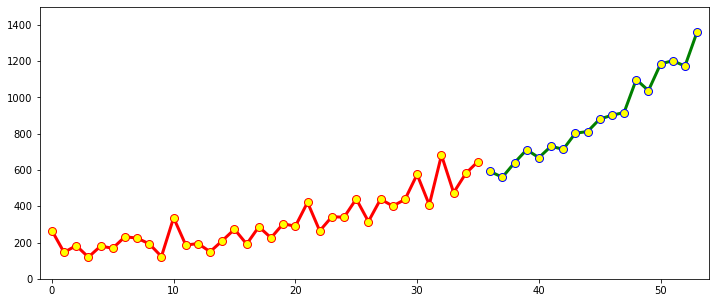

In [83]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=8
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=8
        , mec='blue', mew=1, mfc='yellow' )
plt.xlim([-1,len(S)+N])
plt.ylim([0,1500-1])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

##### 